In [1]:
from sklearn.preprocessing import PolynomialFeatures
import scipy.special
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
import sklearn

import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re

# XGBoost Model to predict returns
to do
 - Do test for 3 month return as well


In [2]:
tmp_df = pd.read_csv('../data/VQ_data.csv')
tmp_df['d'] = pd.to_datetime(tmp_df['d'])
tmp_df = tmp_df.set_index(['d', 'insID'])

In [3]:
min_MCAP = 500
clean_df = tmp_df[tmp_df['MCAP']>min_MCAP]

monthly_df =clean_df.groupby([clean_df.index.get_level_values(1), pd.Grouper(freq='m', level=0)]).last()
monthly_df['log_ret_1m'] = monthly_df['adj_c'].groupby(level='insID').apply(lambda x: np.log(x.shift(-1)) - np.log(x))
monthly_df = monthly_df.unstack('insID').iloc[::1, :].stack('insID')


colmax_list = ['PE', 'PB', 'EVEBIT', 'EVFCF', 'PS', 'PFCF']

for colmax in colmax_list:
    monthly_df[monthly_df[colmax]< 0][colmax] = monthly_df[colmax].max()
    

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [4]:
col_list = ['PE', 'PB', 'PFCF','mom12','EAR_std','mom6','mom3' ,'ROA','FCFROE','ROE','GPA','SUE_Y','RSURP_Y','PFCF', 'Asset_growth' ,'log_ret_1m']
zscore_df = pd.DataFrame()
zscore_df.index = monthly_df.index

for col in col_list:
    col_zscore = col+ '_zscore'
    zscore_tmp_df = monthly_df[col]
    zscore_tmp_df = zscore_tmp_df
    zscore_df[col_zscore] = (zscore_tmp_df - zscore_tmp_df.unstack(level ='d').mean())/zscore_tmp_df.unstack(level ='d').std()



#group by quintiles 

for col in list(set(list(zscore_df.columns)) - set( 'log_ret_1m_zscore')):
    col_group = col + '_group'
    zscore_df[col_group] = pd.qcut(zscore_df[col], 10, labels = range(1, 11))

    
#combined measures
zscore_df['comb_mom'] = zscore_df['mom3_zscore'] + zscore_df['mom6_zscore'] +zscore_df['mom12_zscore']
zscore_df['ear_mom'] = zscore_df['mom3_zscore'] + zscore_df['mom6_zscore'] +zscore_df['mom12_zscore'] + zscore_df['EAR_std_zscore']


In [5]:
monthly3_df =clean_df.groupby([clean_df.index.get_level_values(1), pd.Grouper(freq='m', level=0)]).last()
monthly3_df['log_ret_3m'] = monthly3_df['adj_c'].groupby(level='insID').apply(lambda x: np.log(x.shift(-3)) - np.log(x))
monthly3_df = monthly3_df.unstack('insID').iloc[::3, :].stack('insID')


colmax_list = ['PE', 'PB', 'EVEBIT', 'EVFCF', 'PS', 'PFCF']

for colmax in colmax_list:
    monthly3_df[monthly3_df[colmax]< 0][colmax] = monthly3_df[colmax].max()


    
col_list = ['PE', 'PB', 'PFCF','mom12','EAR_std','mom6','mom3' ,'ROA','FCFROE','ROE','GPA','SUE_Y','RSURP_Y','PFCF', 'Asset_growth' ,'log_ret_3m']
zscore3_df = pd.DataFrame()
zscore3_df.index = monthly3_df.index

for col in col_list:
    col_zscore = col+ '_zscore'
    zscore_tmp_df = monthly3_df[col]
    zscore3_df[col_zscore] = (zscore_tmp_df - zscore_tmp_df.unstack(level ='d').mean())/zscore_tmp_df.unstack(level ='d').std()



#group by quintiles 

for col in list(set(list(zscore3_df.columns)) - set( 'log_ret_3m_zscore')):
    col_group = col + '_group'
    zscore3_df[col_group] = pd.qcut(zscore3_df[col], 10, labels = range(1, 11))



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


# 1 Month Forward Return

### Train Model

In [6]:
model_list = []
for col in zscore_df.columns:
    x = re.search('zscore$', col)
    if(x!=None):
        model_list.append(col)
        
coeff_list = model_list.copy()
coeff_list.remove('log_ret_1m_zscore')

In [7]:
np.random.seed(123)
train_ratio = 0.7

reg_df = zscore_df.dropna()
eval_train_df = reg_df[:int(len(reg_df)*train_ratio)]
eval_test_df =  reg_df[int(len(reg_df)*(1-train_ratio)):]

X_ml = reg_df[coeff_list]
Y_ml = pd.DataFrame(reg_df[['log_ret_1m_zscore']])

#splitting data into train and test
X_train = X_ml[:int(len(X_ml)*train_ratio)]
X_test = X_ml[int(len(X_ml)*(1-train_ratio)):]
Y_train = Y_ml[:int(len(X_ml)*(train_ratio))]
Y_test = Y_ml[int(len(X_ml)*(1-train_ratio)):]

#creating dmatrix for xgboost
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

In [8]:
params = { 'max_depth': [1,2],
           'learning_rate': [0.01,0.02, 0.03, 0.04, 0.05],
           'n_estimators': [100,200,300,400, 500],
           'colsample_bytree': [ 0.2, 0.3,0.4, 0.5, 0.6]}

In [9]:
## TUNE WITH GRIDSEARCH

xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, Y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_esti...
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    seed=20, su

### Model Eval

In [10]:
VIP_df = pd.DataFrame(clf.best_estimator_.feature_importances_, index = X_train.columns).sort_values(0, ascending=True)
eval_train_df.loc[:, 'pred_y'] = clf.predict(X_train)
MSE_train = np.mean((eval_train_df['log_ret_1m_zscore'] - eval_train_df['pred_y'])**2)

print("MSE for train set: ", MSE_train)

#set up group for bin test
for col in ['pred_y']:
    col_group = col + '_group'
    eval_train_df[col_group] = pd.qcut(eval_train_df[col].rank(method='first'), 10, labels = range(1, 11))

MSE for train set:  0.9786009218565539


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


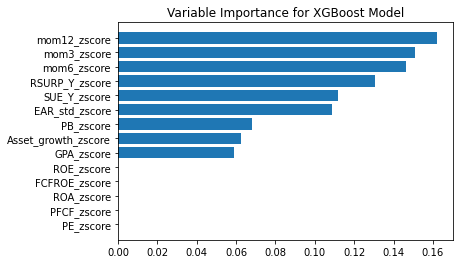

In [11]:
plt.barh(VIP_df.transpose().columns,VIP_df.iloc[:, 0]);
plt.title('Variable Importance for XGBoost Model');

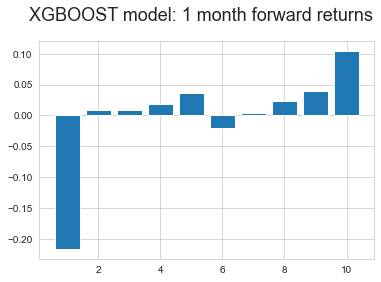

In [12]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey = True)
fig.suptitle('XGBOOST model: 1 month forward returns', fontsize=18, y=1)
ax.bar(range(1, 11) ,eval_train_df.groupby("pred_y_group").mean()['log_ret_1m_zscore']);
ax.set_title('');

### Eval test Set

In [13]:
eval_test_df.loc[:, 'pred_y'] = clf.predict(X_test)
MSE_test = np.mean((eval_test_df['log_ret_1m_zscore'] - eval_test_df['pred_y'])**2)

print("MSE for test set: ", MSE_test)

#set up group for bin test
for col in ['pred_y']:
    col_group = col + '_group'
    eval_test_df[col_group] = pd.qcut(eval_test_df[col].rank(method='first'), 10, labels = range(1, 11))

MSE for test set:  0.9822953225850826


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


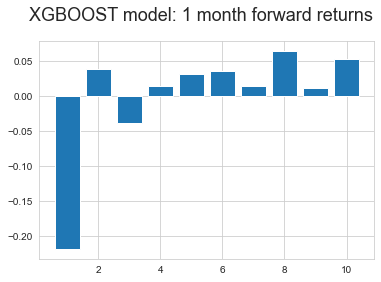

In [14]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey = True)
fig.suptitle('XGBOOST model: 1 month forward returns', fontsize=18, y=1)
ax.bar(range(1, 11) ,eval_test_df.groupby("pred_y_group").mean()['log_ret_1m_zscore']);
ax.set_title('');

# 3 Month Forward Return


In [15]:
np.random.seed(123)
train_ratio = 0.7

reg3_df = zscore3_df.dropna()
eval3_train_df = reg3_df[:int(len(reg3_df)*train_ratio)]
eval3_test_df =  reg3_df[int(len(reg3_df)*(1-train_ratio)):]

X3_ml = reg3_df[['mom3_zscore', 'mom6_zscore', 'mom12_zscore',  'EAR_std_zscore','SUE_Y_zscore', 'RSURP_Y_zscore',
              'ROE_zscore', 'GPA_zscore', 'PFCF_zscore', 'Asset_growth_zscore']]
Y3_ml = pd.DataFrame(reg3_df[['log_ret_3m_zscore']])

#splitting data into train and test
X3_train = X3_ml[:int(len(X3_ml)*train_ratio)]
X3_test = X3_ml[int(len(X3_ml)*(1-train_ratio)):]
Y3_train = Y3_ml[:int(len(X3_ml)*(train_ratio))]
Y3_test = Y3_ml[int(len(X3_ml)*(1-train_ratio)):]

#creating dmatrix for xgboost
dtrain3 = xgb.DMatrix(X3_train, label=Y3_train)
dtest3 = xgb.DMatrix(X3_test, label=Y3_test)

In [16]:
## TUNE WITH GRIDSEARCH
xgbr3 = xgb.XGBRegressor(seed = 20)
clf3 = GridSearchCV(estimator=xgbr3, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf3.fit(X3_train, Y3_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_esti...
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    seed=20, su

In [17]:
VIP3_df = pd.DataFrame(clf3.best_estimator_.feature_importances_, index = X3_train.columns).sort_values(0, ascending=True)
eval3_train_df.loc[:, 'pred_y'] = clf3.predict(X3_train)
MSE3_train = np.mean((eval3_train_df['log_ret_3m_zscore'] - eval3_train_df['pred_y'])**2)

print("MSE for train set: ", MSE_train)

#set up group for bin test
for col in ['pred_y']:
    col_group = col + '_group'
    eval3_train_df[col_group] = pd.qcut(eval3_train_df[col].rank(method='first'), 10, labels = range(1, 11))

MSE for train set:  0.9786009218565539


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


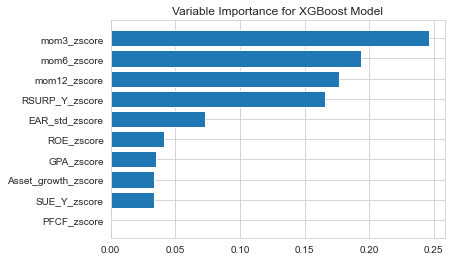

In [18]:
plt.barh(VIP3_df.index.to_list(),VIP3_df.iloc[:, 0]);
plt.title('Variable Importance for XGBoost Model');

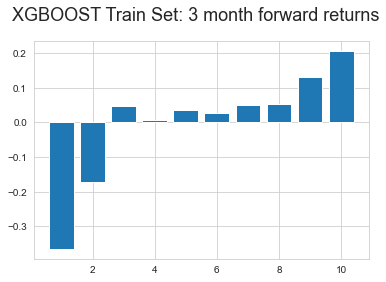

In [19]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey = True)
fig.suptitle('XGBOOST Train Set: 3 month forward returns', fontsize=18, y=1)
ax.bar(range(1, 11) ,eval3_train_df.groupby("pred_y_group").mean()['log_ret_3m_zscore']);
ax.set_title('');

In [20]:
eval3_test_df.loc[:, 'pred_y'] = clf3.predict(X3_test)
MSE3_test = np.mean((eval3_test_df['log_ret_3m_zscore'] - eval3_test_df['pred_y'])**2)

print("MSE for test set: ", MSE3_test)

#set up group for bin test
for col in ['pred_y']:
    col_group = col + '_group'
    eval3_test_df[col_group] = pd.qcut(eval3_test_df[col].rank(method='first'), 10, labels = range(1, 11))

MSE for test set:  0.9632110425468658


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


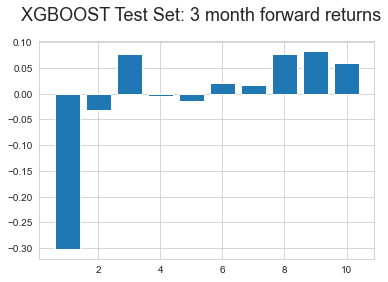

In [21]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey = True)
fig.suptitle('XGBOOST Test Set: 3 month forward returns', fontsize=18, y=1)
ax.bar(range(1, 11) ,eval3_test_df.groupby("pred_y_group").mean()['log_ret_3m_zscore']);
ax.set_title('');